In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [ ]:
# Step 1: Load Data and visualization
# Transformation des données
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [ ]:
# Chargement des données MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
# Création des DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Text(0, 0.5, "Nombre d'images")

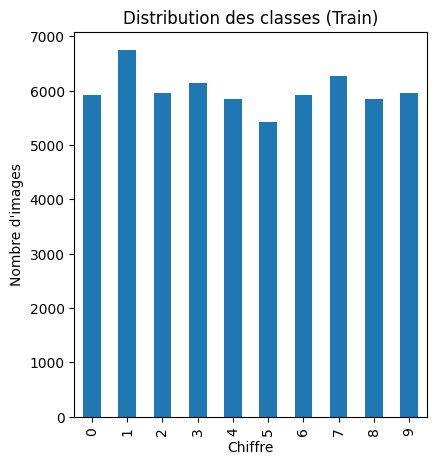

In [ ]:
# Visualisation de la distribution des classes
train_labels = [label for _, label in train_dataset]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
pd.Series(train_labels).value_counts().sort_index().plot(kind='bar')
plt.title('Distribution des classes (Train)')
plt.xlabel('Chiffre')
plt.ylabel('Nombre d\'images')

/tmp/ipython-input-1918742435.py:9: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


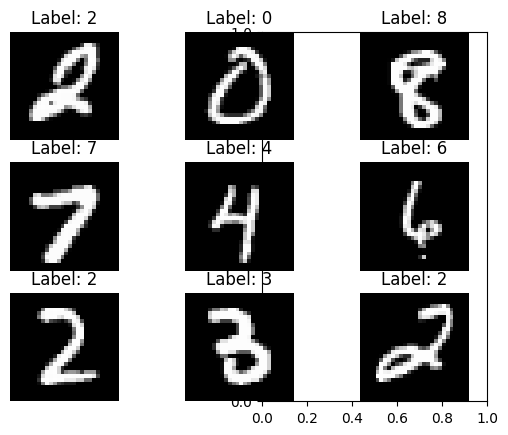

In [ ]:
# Affichage d'un échantillon d'images
plt.subplot(1, 2, 2)
images, labels = next(iter(train_loader))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Step 2: Model Designing
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Architecture modifiée avec filtres 3x3 pour éviter l'erreur de dimension
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 28x28x32
        self.pool1 = nn.MaxPool2d(2, 2)  # 14x14x32

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 14x14x64
        self.pool2 = nn.MaxPool2d(2, 2)  # 7x7x64

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # 7x7x64
        self.pool3 = nn.MaxPool2d(2, 2)  # 3x3x64 (après pooling: 3.5 → 3)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 3 * 3, 100)  # 64*3*3 = 576
        self.fc2 = nn.Linear(100, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Création du modèle
model = CNN().to(device)
print(model)

# Step 3: Train
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement
num_epochs = 10
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    # Mode entraînement
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    # Calcul des métriques d'entraînement
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += targets.size(0)
            correct_val += predicted.eq(targets).sum().item()

    val_loss = val_loss / len(test_loader)
    val_acc = 100. * correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=576, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)
Epoch [1/10], Train Loss: 0.2289, Train Acc: 92.70%, Val Loss: 0.0499, Val Acc: 98.47%
Epoch [2/10], Train Loss: 0.0789, Train Acc: 97.58%, Val Loss: 0.0310, Val Acc: 99.00%
Epoch [3/10], Train Loss: 0.0602, Train Acc: 98.09%, Val Loss: 0.0266, Val Acc: 99.05%
Epoch [4/10], T

Text(0.5, 1.0, 'Loss')

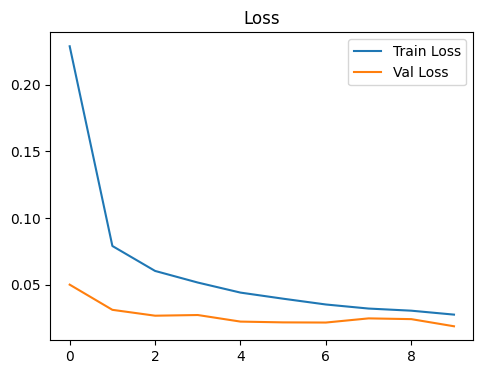

In [ ]:
# Visualisation des courbes d'apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')

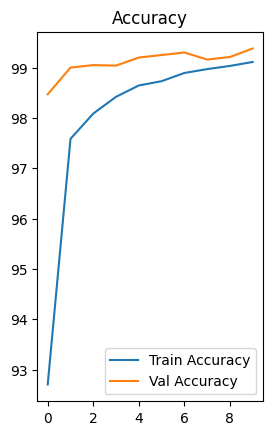

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()


Test Accuracy: 99.38%


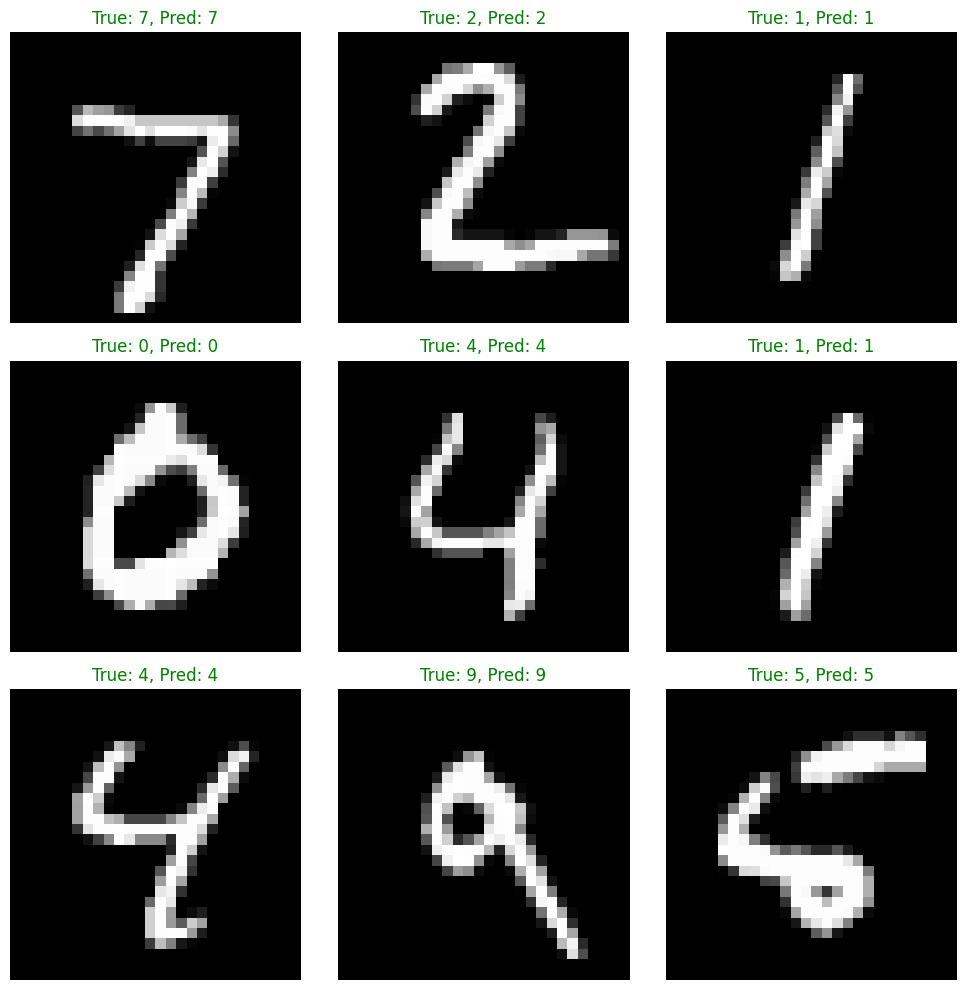

In [ ]:
# Step 4: Test
model.eval()
test_correct = 0
test_total = 0
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        _, predicted = outputs.max(1)

        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

test_acc = 100. * test_correct / test_total
print(f'\nTest Accuracy: {test_acc:.2f}%')

# Visualisation des prédictions
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img, label = test_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')

    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device))
        pred = output.argmax(dim=1).item()

    color = 'green' if pred == label else 'red'
    ax.set_title(f'True: {label}, Pred: {pred}', color=color)
    ax.axis('off')
plt.tight_layout()
plt.show()